In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Data/complaints.csv.zip')
df.iloc[:,:10].head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX
3,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX
4,2021-03-02,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",FL,33325


In [5]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679285 entries, 0 to 1999963
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 679285 non-null  object
 1   Product                       679285 non-null  object
 2   Sub-product                   627113 non-null  object
 3   Issue                         679285 non-null  object
 4   Sub-issue                     528206 non-null  object
 5   Consumer complaint narrative  679285 non-null  object
 6   Company public response       339012 non-null  object
 7   Company                       679285 non-null  object
 8   State                         675680 non-null  object
 9   ZIP code                      528244 non-null  object
 10  Tags                          111909 non-null  object
 11  Consumer consent provided?    679285 non-null  object
 12  Submitted via                 679285 non-null  object
 13

In [7]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [8]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [9]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [10]:
df['category_id'] = df['Product'].factorize()[0]

In [11]:
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

# Mapping Dictionaries
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [12]:
df.head()

,Product,Consumer_complaint_narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
3,Debt collection,Pioneer has committed several federal violatio...,0
8,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",1
9,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...,1


In [13]:
import sys
sys.getsizeof(df)/(1024**3)

0.7826486974954605

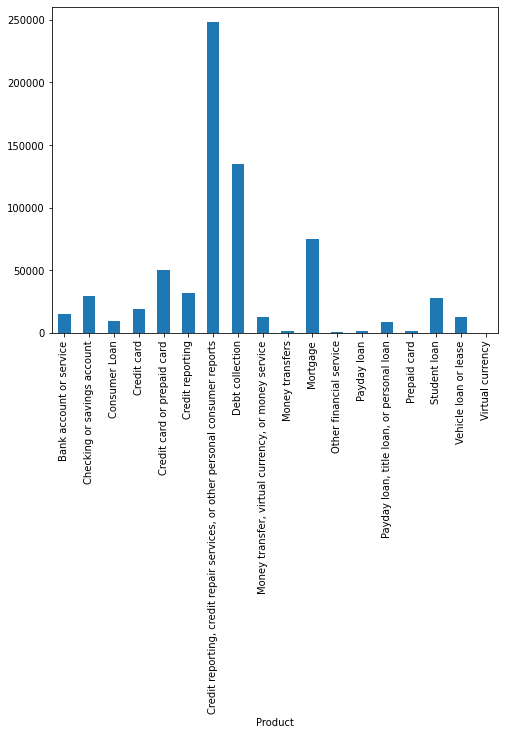

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

# Undersample the High Frequency Classes - Using Median Count

In [15]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    248115
Debt collection                                                                 134651
Mortgage                                                                         75042
Credit card or prepaid card                                                      50365
Credit reporting                                                                 31588
Checking or savings account                                                      29404
Student loan                                                                     27735
Credit card                                                                      18838
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               12994
Vehicle loan or lease                                                            12287
Consumer Loan                              

In [16]:
print('Minority Class Count : ', df['Product'].value_counts().min())
print('Majority Class Count : ', df['Product'].value_counts().max())

Minority Class Count :  16
Majority Class Count :  248115


In [17]:
# Percentage of majority relative to the minority class
samplingStrategy = 0.01

In [18]:
import numpy as np

# Undersampling using sampling strategy 
nsamples_per_class = np.int16(df['Product'].value_counts().min()/samplingStrategy)
undersample = lambda df: df.loc[np.random.choice(a=df.index, size=min(len(df.index), nsamples_per_class), replace=False)]
df_bal = df.groupby(['Product'], as_index=False).apply(undersample)

print(df_bal.shape)

(25655, 3)


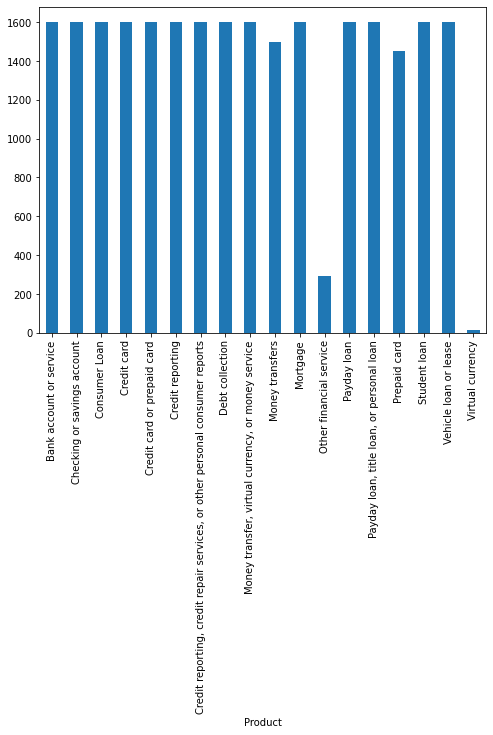

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_bal.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [20]:
df = df_bal

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
features.shape

(25655, 70530)

In [22]:
import sys
sys.getsizeof(features)/(1024**3)

5.960464477539063e-08

In [23]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
df_feat = pd.DataFrame(columns=['Product', 'Unigrams', 'Bigrams'])

for product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])

  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

  # Top N most correlated unigrams and bigrams for each category
  df_cat = pd.DataFrame(index=range(N), columns=['Product', 'Unigrams', 'Bigrams'])
  df_cat['Product'] = product
  df_cat['Unigrams'] = unigrams[-N:]
  df_cat['Bigrams'] = bigrams[-N:]
  
  df_feat = pd.concat([df_feat, df_cat], axis=0, ignore_index=True)

In [24]:
df_feat.head(20)

,Product,Unigrams,Bigrams
0,Bank account or service,bank,checking account
1,Bank account or service,overdraft,overdraft fees
2,Checking or savings account,checking,savings account
3,Checking or savings account,branch,checking account
4,Consumer Loan,car,car loan
5,Consumer Loan,vehicle,auto loan
6,Credit card,macy,synchrony bank
7,Credit card,card,credit card
8,Credit card or prepaid card,barclays,credit limit
9,Credit card or prepaid card,card,credit card


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Baseline Classifiers

- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

# Optimize Baseline Models Using GridSearchCV

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

## Multinomial Naive Bayes Classifier

In [ ]:
# Implement the grid search
pipe = Pipeline([("tfidf", TfidfVectorizer()), 
                 ("classifier", MultinomialNB())])

params = {'classifier__alpha':[1, 0.1]}

gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Multinomial Naive Bayes classifier  
gridCV.fit(X_train, y_train)

In [28]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__alpha': 0.1}
0.6087003320245721


In [29]:
# Evaluate the Multinomial Naive Bayes classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.52      0.54      0.53       402
                                                 Checking or savings account       0.52      0.60      0.56       405
                                                               Consumer Loan       0.45      0.36      0.40       370
                                                                 Credit card       0.51      0.51      0.51       412
                                                 Credit card or prepaid card       0.50      0.47      0.48       401
                                                            Credit reporting       0.64      0.60      0.62       409
Credit reporting, credit repair services, or other personal consumer reports       0.53      0.58      0.55       386
                                                       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression Classifier

In [ ]:
# Implement the grid search
pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                 ('classifier', LogisticRegression())])

params = {'classifier__C':[0.5, 1],
          'classifier__penalty':['l2', None]}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Logistic Regression classifier
gridCV.fit(X_train, y_train)

In [31]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__C': 1, 'classifier__penalty': 'l2'}
0.625798976325087


In [32]:
# Evaluate the Logistic Regression classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.54      0.57      0.56       402
                                                 Checking or savings account       0.59      0.58      0.58       405
                                                               Consumer Loan       0.45      0.42      0.44       370
                                                                 Credit card       0.57      0.61      0.59       412
                                                 Credit card or prepaid card       0.53      0.48      0.51       401
                                                            Credit reporting       0.65      0.61      0.63       409
Credit reporting, credit repair services, or other personal consumer reports       0.54      0.58      0.56       386
                                                       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Linear Support Vector Machine Classifier

In [ ]:
# Implement the grid search
pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                 ('classifier', LinearSVC())])

params = {'classifier__loss':['squared_hinge', 'hinge']}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Linear SVC classifier
gridCV.fit(X_train, y_train)

In [34]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__loss': 'squared_hinge'}
0.6111946753996638


In [35]:
# Evaluate the Linear SVC classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.51      0.49      0.50       402
                                                 Checking or savings account       0.53      0.55      0.54       405
                                                               Consumer Loan       0.45      0.41      0.43       370
                                                                 Credit card       0.53      0.54      0.54       412
                                                 Credit card or prepaid card       0.50      0.46      0.48       401
                                                            Credit reporting       0.62      0.62      0.62       409
Credit reporting, credit repair services, or other personal consumer reports       0.57      0.54      0.55       386
                                                       

## Random Forest Classifier

In [36]:
# Implement the grid search
pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                 ('classifier', RandomForestClassifier())])

params = {'classifier__n_estimators':[50, 100],
          'classifier__max_depth':[2, 3],
          'classifier__random_state':[0, None]}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Random Forest classifier
gridCV.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                      

In [37]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__random_state': None}
0.4810052858182242


In [38]:
# Evaluate the Random Forest classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.38      0.25      0.30       402
                                                 Checking or savings account       0.41      0.45      0.43       405
                                                               Consumer Loan       0.24      0.18      0.20       370
                                                                 Credit card       0.62      0.11      0.19       412
                                                 Credit card or prepaid card       0.38      0.37      0.37       401
                                                            Credit reporting       0.44      0.33      0.38       409
Credit reporting, credit repair services, or other personal consumer reports       0.17      0.55      0.26       386
                                                       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Selection using Cross Validation

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(alpha=0.1),
    LogisticRegression(C=0.5, random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)

  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


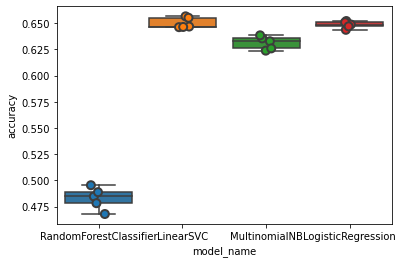

In [40]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [41]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.650283
LogisticRegression        0.648529
MultinomialNB             0.631339
RandomForestClassifier    0.483025
Name: accuracy, dtype: float64

# Best Model

In [42]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

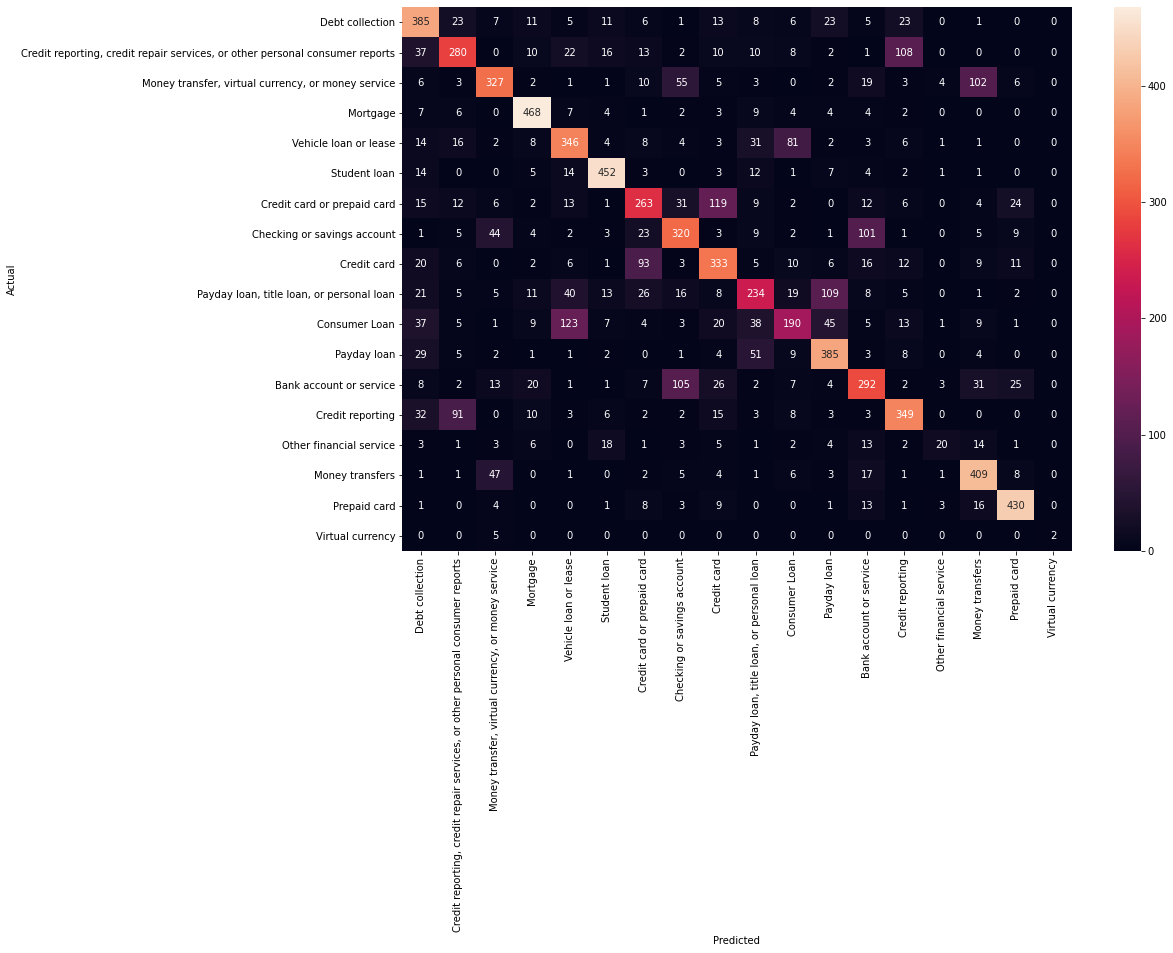

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [44]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 100:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Consumer Loan' predicted as 'Vehicle loan or lease' : 123 examples.


Product                       Consumer_complaint_narrative
2 1698334  Consumer Loan  On XX/XX/XXXX I scheduled a payment online to ...
  1674670  Consumer Loan  I have been called by Wachovia dealers service...
  152465   Consumer Loan  I purchased a new car, and I gave this one bac...
  1736148  Consumer Loan  I gave a cash down payment and a Nissan Altima...
  1735102  Consumer Loan  In XXXX, my vehicle, which is financed through...
...                  ...                                                ...
  775096   Consumer Loan  The BANK HAD SOMEONE TO TAKE MY CAR WITHOUT ME...
  1641842  Consumer Loan  My name is XXXX I 'm with XXXX out of XXXX, TX...
  1621347  Consumer Loan  History of account : I am a co-signer on XXXX ...
  1720486  Consumer Loan  I purchased a vehicle from a used car dealersh...
  1687467  Consumer Loan  Well i am a XXXX year old woman who is on her ...

[123 rows x 2 columns]


'Bank account or service' predicted as 'Checking or savings account' : 105 examples.


Product                       Consumer_complaint_narrative
0 1688389  Bank account or service  I am a XXXX on limited funds. On XXXX XXXX, I ...
  1709458  Bank account or service  On the XXXX of XXXX Bank of America closed my ...
  1653121  Bank account or service  Case # XXXX For XXXX XXXX status shows the acc...
  1086432  Bank account or service  Account was closed by bank they wo n't release...
  1648521  Bank account or service  WHILE BANKING WITH BANK OF AMERICA I ASKED TO ...
...                            ...                                                ...
  1745271  Bank account or service  Regarding dispute # XXXX I will continue filin...
  1582453  Bank account or service  THIS IS THE SECOND TIME WITHIN A FEW WEEKS THA...
  1735639  Bank account or service  I opened a " Pinnacle Checking '' account on X...
  1747354  Bank account or service  Comerica Bank refuses to reimburse me for frau...
  1700405  Bank account or service  On XXXX/XXXX/XXXX I made a {$600.00} cash depo...

[105 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Credit card' : 119 examples.


Product                       Consumer_complaint_narrative
4 1837035  Credit card or prepaid card  I was interested in applying for the Chase XXX...
  219257   Credit card or prepaid card  today XX/XX/20 I've wasted over 5 hours ( 2 on...
  99336    Credit card or prepaid card  On XX/XX/2019, I paid {$60.00} for 18 holes of...
  692927   Credit card or prepaid card  CitiBank sent a 1099 to the IRS for an alleged...
  152177   Credit card or prepaid card  A bad actor used our stolen identities to obta...
...                                ...                                                ...
  256367   Credit card or prepaid card  I applied for the Credit card in XXXX got appr...
  1898367  Credit card or prepaid card  Hello, BB & T has refused to engage in adequat...
  1894205  Credit card or prepaid card  I called the customer service number XXXX XXXX...
  906490   Credit card or prepaid card  I received an email for 0 % interest on balanc...
  223459   Credit card or prepaid card  Capital One Bank has been 3 months on changing...

[119 rows x 2 columns]


'Payday loan, title loan, or personal loan' predicted as 'Payday loan' : 109 examples.


Product                       Consumer_complaint_narrative
13 1781870  Payday loan, title loan, or personal loan  I have a loan with Mobiloans LLC which I have ...
   77077    Payday loan, title loan, or personal loan  A Payday Loan Company Money 4 you in XXXX, Uta...
   1900297  Payday loan, title loan, or personal loan  Borrowed {$1000.00} from Big Picture Loans and...
   593496   Payday loan, title loan, or personal loan  My loan was sent to court through XXXX county ...
   788525   Payday loan, title loan, or personal loan  Got Loan fr om company on approximately  XXXX ...
...                                               ...                                                ...
   861910   Payday loan, title loan, or personal loan  I contacted Cash Central via Telephone Calls, ...
   298685   Payday loan, title loan, or personal loan  I received a letter dated XX/XX/XXXX that says...
   834112   Payday loan, title loan, or personal loan  You contacted them and they said the date of t...
   782050   Payday loan, title loan, or personal loan  My customer number is XXXX. I requested a XXXX...
   252573   Payday loan, title loan, or personal loan  i signed up with quickbridge they are a cash a...

[109 rows x 2 columns]


'Checking or savings account' predicted as 'Bank account or service' : 101 examples.


Product                       Consumer_complaint_narrative
1 470769   Checking or savings account  I opened 2 Trust Checking Accounts about 4 mon...
  495606   Checking or savings account  I made the mistake of helping a gentleman that...
  799462   Checking or savings account  I created a checking account on  XXXX / XXXX /...
  1962462  Checking or savings account  My checking account was accessed fraudulently ...
  554438   Checking or savings account  I made two payments from my checking account w...
...                                ...                                                ...
  804607   Checking or savings account  I have a checking account with key bank. They ...
  884874   Checking or savings account  The whole crux of the matter is this : I was c...
  933084   Checking or savings account  A collections attorney has frozen funds in my ...
  1870569  Checking or savings account  I have called Wells Fargo multiple times and h...
  698213   Checking or savings account  I have been able to resolve my 2 CD issues how...

[101 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 108 examples.


Product                       Consumer_complaint_narrative
6 1813768  Credit reporting, credit repair services, or o...  I have requested my credit report since  XXXX ...
  1188     Credit reporting, credit repair services, or o...  On XX/XX/2019 I started the process to buy me ...
  991924   Credit reporting, credit repair services, or o...  Transunion is the only credit bureau that is r...
  113888   Credit reporting, credit repair services, or o...  XXXX XXXX # XXXX is in collection status on my...
  702380   Credit reporting, credit repair services, or o...  I have tried on two different occasions in XXX...
...                                                      ...                                                ...
  1984919  Credit reporting, credit repair services, or o...  On XX/XX/18 I obtained by Equifax credit repor...
  347913   Credit reporting, credit repair services, or o...  I applied for a new phone with XXXX. They came...
  866390   Credit reporting, credit repair services, or o...  I have filed multiple complaints against XXXX ...
  992781   Credit reporting, credit repair services, or o...  have been trying to get negative items removed...
  506889   Credit reporting, credit repair services, or o...  THEY HAVE NOT ADDRESSED THE FACT THAT THEIR IN...

[108 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Money transfers' : 102 examples.


Product                       Consumer_complaint_narrative
8 641184   Money transfer, virtual currency, or money ser...  I use M & T bank. I get scammed recently by so...
  1003069  Money transfer, virtual currency, or money ser...  I purchased item on XXXX that has been scam. X...
  1900180  Money transfer, virtual currency, or money ser...  Paypal is a money transmitter. I have used Pay...
  645245   Money transfer, virtual currency, or money ser...  My complaint is simple. PayPal has no customer...
  157904   Money transfer, virtual currency, or money ser...  On Monday XX/XX/XXXX I negotiated a vacation r...
...                                                      ...                                                ...
  151709   Money transfer, virtual currency, or money ser...  Western Union repeatedly uses exchange rates f...
  1966705  Money transfer, virtual currency, or money ser...  I won a sneaker contests on XXXX for the XXXX ...
  821314   Money transfer, virtual currency, or money ser...  My complaint is about Venmo, the person-to-per...
  929938   Money transfer, virtual currency, or money ser...  I went to a local grocery store to wire transf...
  823651   Money transfer, virtual currency, or money ser...  I wired money to XXXX. Through western union a...

[102 rows x 2 columns]

In [45]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [46]:
from sklearn.feature_selection import chi2

N = 2
df_feat = pd.DataFrame(columns=['Product', 'Unigrams', 'Bigrams'])

for product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]

  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]

  # Top N most correlated unigrams and bigrams for each category
  df_cat = pd.DataFrame(index=range(N), columns=['Product', 'Unigrams', 'Bigrams'])
  df_cat['Product'] = product
  df_cat['Unigrams'] = unigrams[-N:]
  df_cat['Bigrams'] = bigrams[-N:]

  df_feat = pd.concat([df_feat, df_cat], axis=0, ignore_index=True)

In [47]:
df_feat.head(30)

,Product,Unigrams,Bigrams
0,Bank account or service,bank,xx 2016
1,Bank account or service,scottrade,joint account
2,Checking or savings account,bank,rights process
3,Checking or savings account,branch,deposited checks
4,Consumer Loan,car,drive time
5,Consumer Loan,vehicle,inquire credit
6,Credit card,card,credit card
7,Credit card,discover,balance transfer
8,Credit card or prepaid card,card,capital reporting
9,Credit card or prepaid card,barclays,want close


In [48]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]

text_features = tfidf.transform(texts)
predictions = model.predict(text_features)

for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Student loan'

"I can't get the money out of the country."
  - Predicted as: 'Money transfers'

"I have no money to pay my tuition"
  - Predicted as: 'Payday loan'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Money transfer, virtual currency, or money service'



In [49]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.61      0.73      0.66       528
                                                 Checking or savings account       0.61      0.54      0.57       519
                                                               Consumer Loan       0.70      0.60      0.64       549
                                                                 Credit card       0.82      0.90      0.86       521
                                                 Credit card or prepaid card       0.59      0.65      0.62       530
                                                            Credit reporting       0.84      0.87      0.85       519
Credit reporting, credit repair services, or other personal consumer reports       0.56      0.51      0.53       519
                                                       

In [50]:
metrics.f1_score(y_test, y_pred, average='weighted')

0.6411085363648058